In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm

#import prettyplotlib as ppl
import matplotlib.pyplot as plt
import matplotlib as mpl
#import prettyplotlib as ppl
#from prettyplotlib import brewer2mpl
import matplotx
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 


# Set plot style
#context="paper" context="paper", style="darkgrid",
#rc={"axes.facecolor": "0.96"}
# Set plot and dataframe style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"}, palette="tab10")

fontsize = "large"
params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
         }
          
plt.rcParams.update(params)
plt.rc('text', usetex=True)

pd.set_option('display.max_columns', 50)

In [16]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "energy": [], "standard_error":[],"standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error = np.mean(standard_errors_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["energy"].append(mean_energy_alpha)
        data_dict["standard_error"].append(standard_error)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe


In [34]:
cycle=["#82e2ff",  # blue
       "#ffca85",  # orange
       "#61ffca",  # green
       "#ff6767",  # red
       "#a277ff",  # purple
       "#f694ff",  # magenta
       "#6d6d6d",  # gray
       ]



def plotter(data, sampler, label_N_particles, label_time, label_sigma, index): 
    N_range = data[label_N_particles]
    t_array = data[label_time]
    std = data[label_sigma]
    plt.plot(N_range, t_array, label=sampler, color=cycle[index]) 
    plt.errorbar(N_range,
                 t_array,
                 yerr=std,
                 fmt=':o',
                 color=cycle[index],
                 ecolor=cycle[index],
                 markersize=3.5,
                 lw=1.0,
                 elinewidth=1.5,
                 capsize=3,
                )
    #plt.scatter(N_range, t_array, marker="*", s=std)

def plot_dracula(datasets, labels, xlabel, ylabel, features):
    """
    datasets: a list containing the datasets
    labels: a list containing the labels in the legend
    xlabel: xlabel
    ylabel: ylabel
    features: features[0]:x-axis, features[1]:y-axis, features[2]:std y-axis
    """
    with plt.style.context(matplotx.styles.duftify(matplotx.styles.dracula)): 
        for i in range(len(datasets)): 
            plotter(datasets[i], labels[i], features[0], features[1], features[2], i)
        plt.xlabel(xlabel)
        matplotx.ylabel_top(ylabel)
        matplotx.line_labels()
        plt.grid(False)
    plt.savefig(fig_path("time_comparison.pdf"), bbox_inches='tight')

    
"""
def strip_plot(data,features,xlabels,figure_name):
    fig, axes = plt.subplots(nrows=len(features), ncols=int(len(features)/2), figsize=(6, 4), tight_layout=True, dpi=200)
    #sns.set(rc={"axes.facecolor": "1.00"})
    for i in range(len(features)):
        mean = np.mean(data[features[i]])
        std = np.std(data[features[i]])
        #axes[i].errorbar(x=mean, xerr=std, color="C0")
        sns.pointplot()
        sns.stripplot(data=data, x=features[i], color=".25", ax=axes[i])
        axes[i].set(xlabel=xlabels[i])
        axes[i].grid(False)
        #axes[i].set_facecolor(1.00)
    sns.despine()
    fig.savefig(fig_path(figure_name), bbox_inches='tight')
   
def point_plot(datasets, features, xlabels, figure_name): 
    fig, axes = plt.subplot(nrows=len(features), ncols=1, figsize=(6,4), tight_layout=True, dpi=200)
    for i in range(len(features)): 
        data1 = datasets[0]
        data2 = datasets[1]
        N1 = data1["nparticles"][0]
        N2 = data2["nparticles"][0]
        mean1 = np.mean(data1[features[0]])
        mean2 = np.mean(data2[features[0]])
        std1 = np.std(data1[features[0]])
        std2 = np.std(data2[features[0]])
        sns.pointplot(x=)
"""   
def line_plot(data, features, labels, xlabel, ylabel, figure_name): 
    fig, ax = plt.subplots(1, figsize=(6, 4), tight_layout=True, dpi=200)
    with plt.style.context(matplotx.styles.dufte):
        for i in range(len(data)): 
            
            sns.lineplot(data=data[i], 
                         x=features[0], 
                         y=features[1], 
                         ax=ax, 
                         label=labels[i], 
                         legend=False, 
                         color=sns.color_palette()[i])
            
            ax.errorbar(data[i][features[0]], 
                        data[i][features[1]], 
                        yerr=data[i][features[2]], 
                        ecolor=sns.color_palette()[i], 
                        fmt=' ', 
                        zorder=-1)
        ax.set(xlabel=xlabel)
        matplotx.ylabel_top(ylabel)
        #ax.legend(False)
        matplotx.line_labels()
        #ax.legend()
        #ax.grid(False)
        fig.savefig(fig_path(figure_name), bbox_inches='tight')
        
def line_plot_no_error(data, features, labels, xlabel, ylabel, figure_name): 
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 4), tight_layout=True, dpi=200)
    with plt.style.context(matplotx.styles.dufte):
        for i in range(len(data)): 
            sns.lineplot(data=data[i], 
                         x=features[0], 
                         y=features[i+1], 
                         ax=axes[i], 
                         label=labels[i], 
                         legend=False, 
                         color=sns.color_palette()[i])
            axes[0].hlines(1.5, 0.1, 1.0, ls="dashed", label="Exact")
        axes.set(xlabel=xlabel)
        matplotx.ylabel_top(ylabel)
        #ax.legend(False)
        matplotx.line_labels()
        #ax.grid(False)
        fig.savefig(fig_path(figure_name), bbox_inches='tight')

        


In [8]:
data_path = "/home/jeb/Documents/FYS4411/FYS4411-Project1/data"
ASHONIB_data = pd.read_csv(data_path + "/grid_search_ashonib_rwm.csv")

IndexError: list index out of range

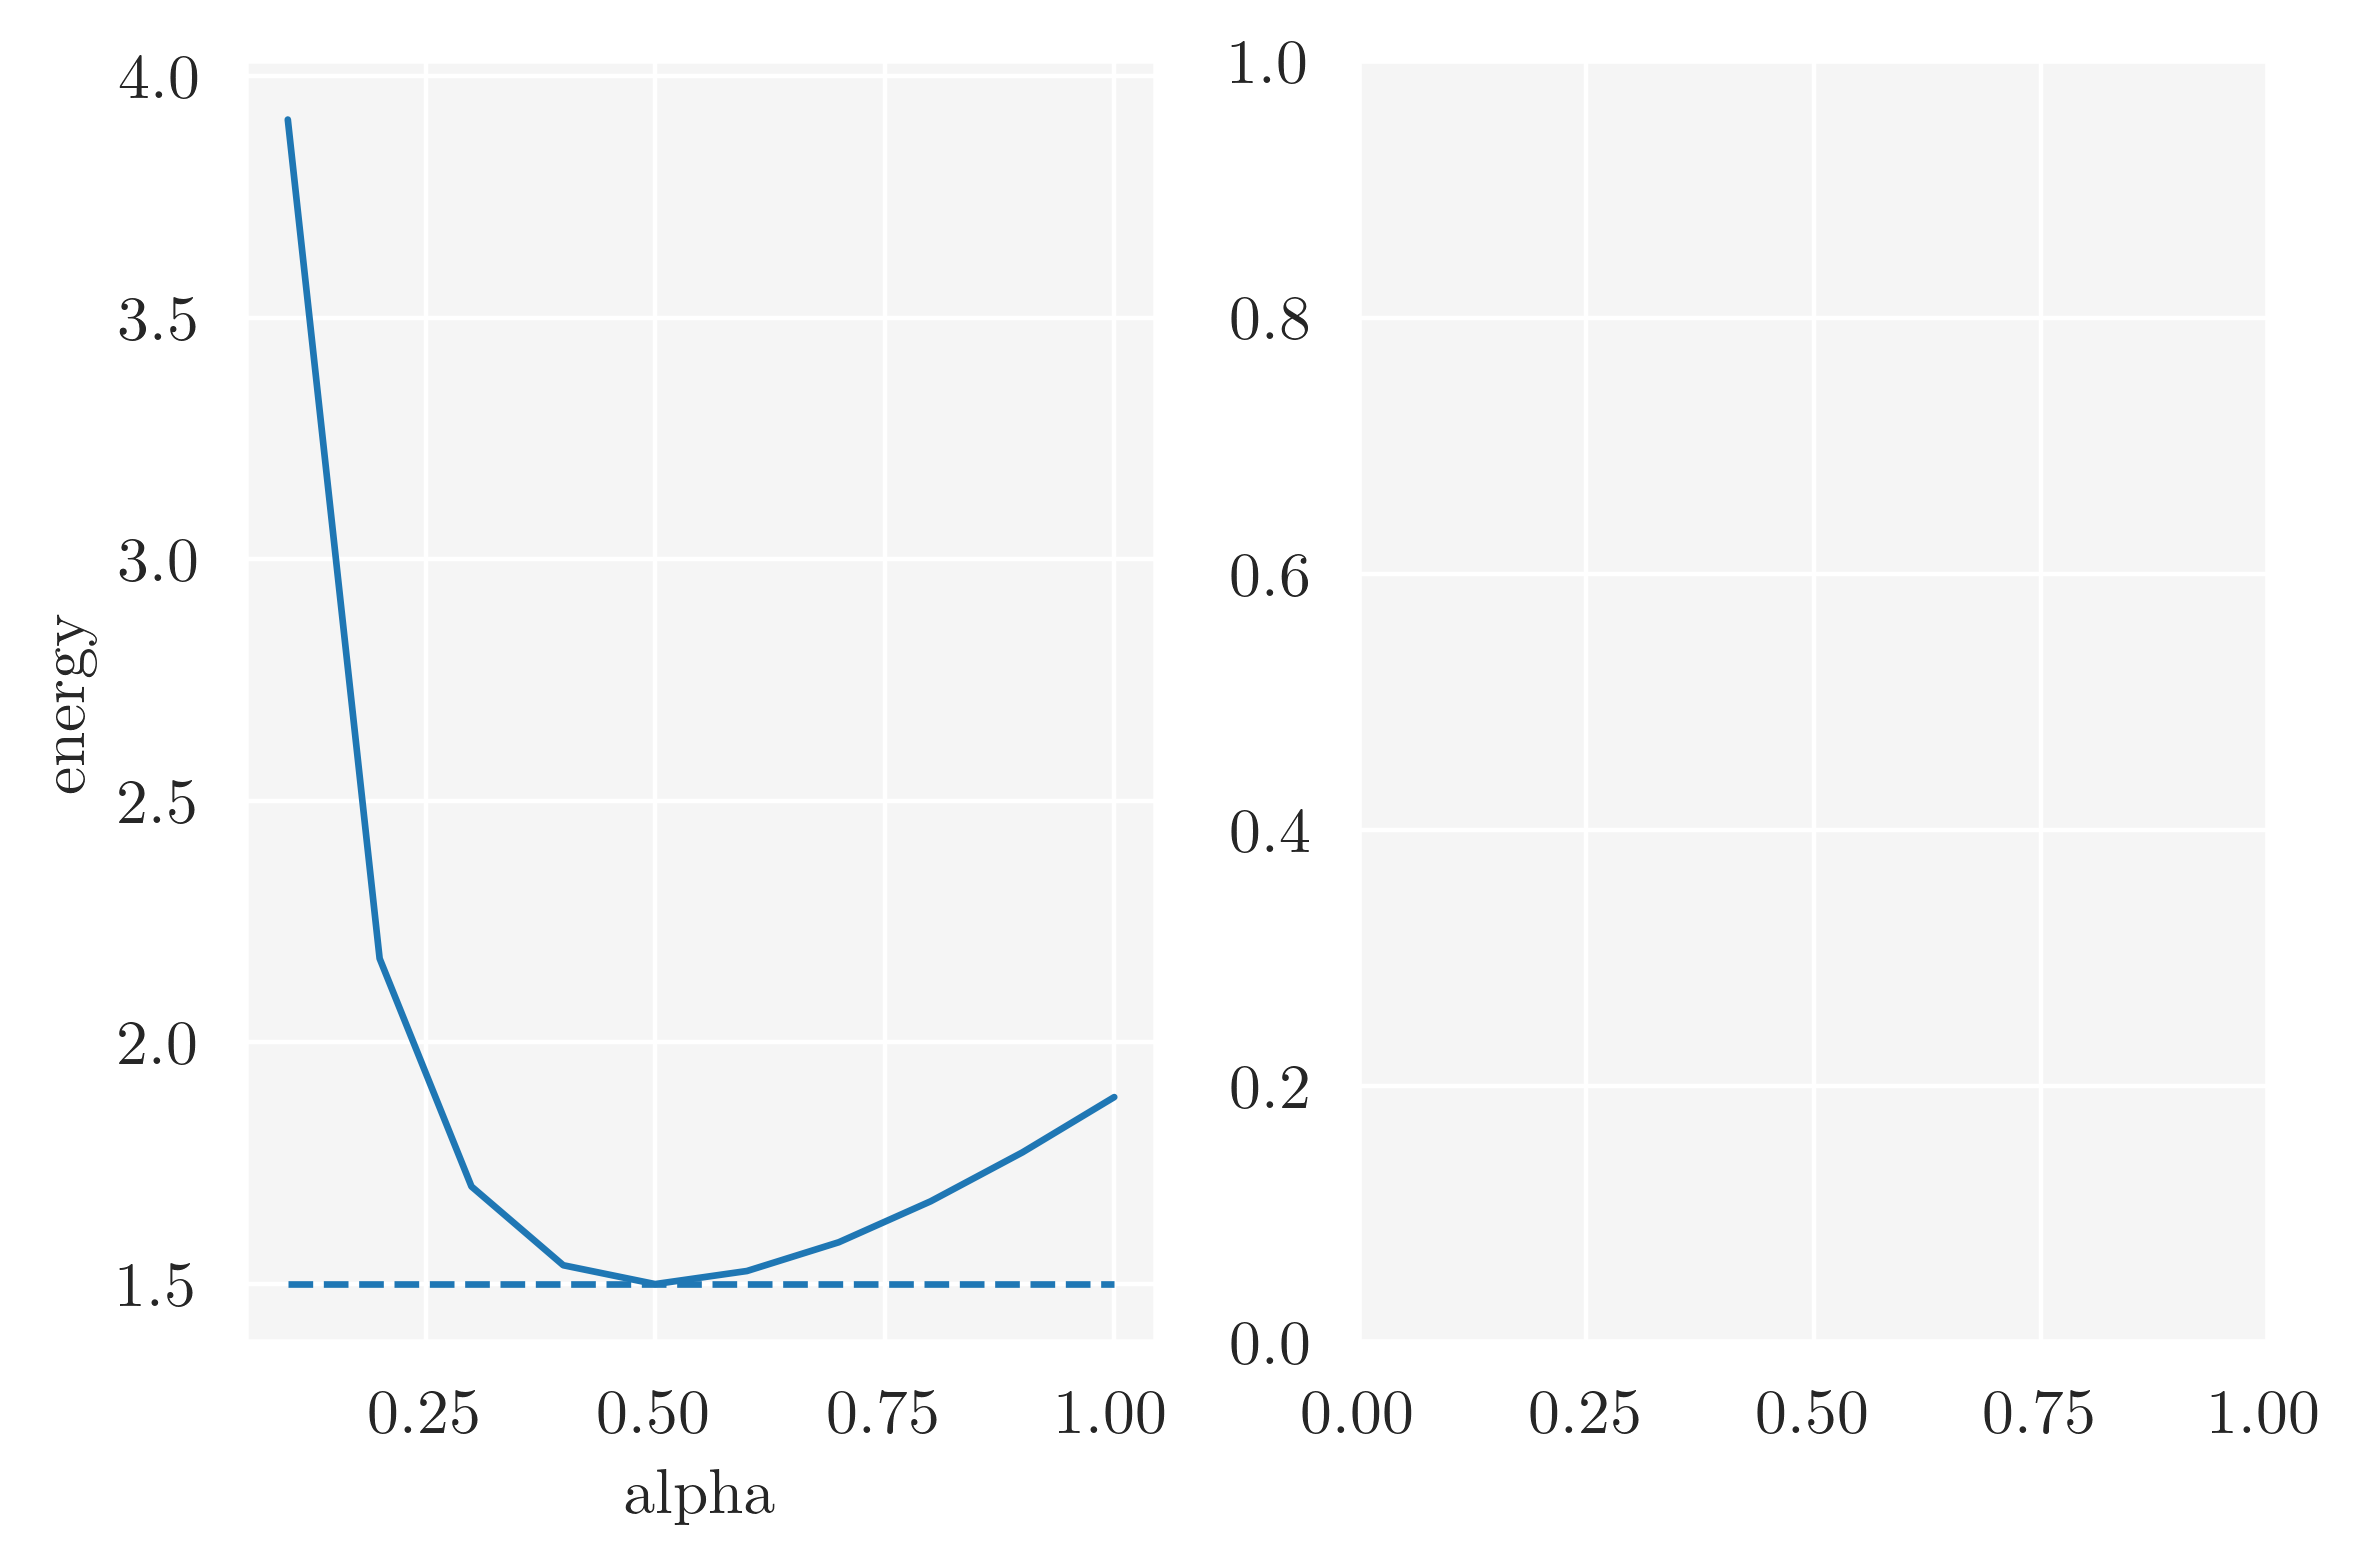

In [21]:
ASHONIB_means = {"N": [], "alpha": [],"energy": [], "error": []}
N_ = [1, 10, 100, 500]
alphas = np.linspace(0.1, 1.0, 10)
for N in N_: 
    for i, alpha in enumerate(alphas): 
        mean_energy = np.mean(ASHONIB_data["scaled_energy"][ASHONIB_data["alpha"]==alpha][ASHONIB_data["nparticles"]==N])
        mean_std = np.mean(ASHONIB_data["scaled_std_error"][ASHONIB_data["alpha"]==alpha][ASHONIB_data["nparticles"]==N])
        ASHONIB_means["N"].append(N)
        ASHONIB_means["alpha"].append(alpha)
        ASHONIB_means["energy"].append(mean_energy)
        ASHONIB_means["error"].append(mean_std)
        
ASHONIB_means = pd.DataFrame(ASHONIB_means)
ASHONIB_N1 = ASHONIB_means[ASHONIB_means["N"]==1]
ASHONIB_N10 = ASHONIB_means[ASHONIB_means["N"]==10]
ASHONIB_N100 = ASHONIB_means[ASHONIB_means["N"]==100]
ASHONIB_N500 = ASHONIB_means[ASHONIB_means["N"]==500]

data_list = [ASHONIB_N1, ASHONIB_N10, ASHONIB_N100, ASHONIB_N500]

line_plot_no_error(data_list, ["alpha", "energy"], ["1", "10", "100", "500"], r'$\alpha$', r'$\langle\mathrm{E}\rangle/N$', "grid_search_RWM_spherical.pdf" )
            

In [10]:
AEHONIB_data = pd.read_csv(data_path +  "/aehonib.csv")
AEHONIB_data

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,warmup_cycles,tuning_cycles,optimize_cycles
0,1,10,3,0.194872,0.01,0.500782,24.142412,0.000304,0.000247,2.414241,0.000304,0.000247,0.374454,262144,375144,5000,11000,97000
1,2,10,3,0.194872,0.01,0.502515,24.144200,0.000852,0.002320,2.414420,0.000852,0.002320,0.375935,262144,352144,5000,11000,74000
2,3,10,3,0.194872,0.01,0.500112,24.142164,0.000043,0.000005,2.414216,0.000043,0.000005,0.379044,262144,378144,5000,11000,100000
3,4,10,3,0.194872,0.01,0.504094,24.145205,0.001509,0.006095,2.414521,0.001509,0.006095,0.375149,262144,345144,5000,11000,67000
4,1,10,3,0.194872,0.01,0.500514,24.142174,0.000204,0.000106,2.414217,0.000204,0.000106,0.372971,262144,376144,5000,12000,97000
5,2,10,3,0.235795,0.01,0.499089,24.141999,0.000298,0.000252,2.414200,0.000298,0.000252,0.276077,262144,376144,5000,15000,94000
6,3,10,3,0.194872,0.01,0.498593,24.141752,0.000519,0.000752,2.414175,0.000519,0.000752,0.378403,262144,365144,5000,12000,86000
7,4,10,3,0.194872,0.01,0.499775,24.142089,0.000083,0.000019,2.414209,0.000083,0.000019,0.376503,262144,378144,5000,11000,100000
8,1,10,3,0.214359,0.01,0.502492,24.143293,0.000867,0.002080,2.414329,0.000867,0.002080,0.325092,262144,350144,5000,12000,71000
9,2,10,3,0.214359,0.01,0.501216,24.142864,0.000403,0.000471,2.414286,0.000403,0.000471,0.325298,262144,377144,5000,12000,98000


In [11]:


strip_plot(AEHONIB_data, ["scaled_energy", "scaled_std_error", "alpha"], [r'$\langle \mathrm{E}\rangle/N$', r'$\sigma$', r'$\alpha$'], "aehonib_opt.pdf")

NameError: name 'strip_plot' is not defined

In [12]:
aehoib_data = pd.read_csv(data_path +  "/aehoib.csv")
"""
box_plot(aehoib_data, 
         ["energy", "std_error","alpha"],
         [r'$\langle \mathrm{E}\rangle$', r'$\sigma$', r'$\alpha$'], 
         "aehoib_bp.pdf",
        )
"""
        
mean_energy = np.mean(aehoib_data["energy"])
std_error_energy = np.mean(aehoib_data["std_error"])
print(f"The energy is measured to be {mean_energy}+-{std_error_energy}")
print(mean_energy)
print(std_error_energy)

The energy is measured to be 24.46439019785126+-0.0010390652333524529
24.46439019785126
0.0010390652333524529


In [27]:
df_A_RWM = pd.read_csv(data_path + "/data_A_RWM.csv")
df_J_RWM = pd.read_csv(data_path + "/data_J_RWM.csv")
df_A_LMH = pd.read_csv(data_path + "/data_A_LMH.csv")
df_J_LMH = pd.read_csv(data_path + "/data_J_LMH.csv")
N = [1, 10, 50, 100, 500]
data_ARWM = {"N": [], "Mean_time": [], "Std_time": [], "Sampler": ["RWM"]}
data_JRWM = {"N": [], "Mean_time": [], "Std_time": [], "Sampler": ["JAX RWM"]}
data_ALMH = {"N": [], "Mean_time": [], "Std_time": [], "Sampler": ["LMH"]}
data_JLMH = {"N": [], "Mean_time": [], "Std_time": [], "Sampler": ["JAX LMH"]}
means_A_RWM = []; stds_A_RWM = []
means_J_RWM = []; stds_J_RWM = []
means_A_LMH = []; stds_A_LMH = []
means_J_LMH = []; stds_J_LMH = []
for n in N:
    times_A_RWM = df_A_RWM["Time"][df_A_RWM["N"]==n]
    times_J_RWM = df_J_RWM["Time"][df_J_RWM["N"]==n]
    times_A_LMH = df_A_LMH["Time"][df_A_LMH["N"]==n]
    times_J_LMH = df_J_LMH["Time"][df_J_LMH["N"]==n]
    means_A_RWM.append(np.mean(times_A_RWM))
    means_J_RWM.append(np.mean(times_J_RWM))
    means_A_LMH.append(np.mean(times_A_LMH))
    means_J_LMH.append(np.mean(times_J_LMH))
    stds_A_RWM.append(np.std(times_A_RWM))
    stds_J_RWM.append(np.std(times_J_RWM))
    stds_A_LMH.append(np.std(times_A_LMH))
    stds_J_LMH.append(np.std(times_J_LMH))
    data_ARWM["N"].append(n)
    data_ARWM["Mean_time"].append(np.mean(times_A_RWM))
    data_ARWM["Std_time"].append(np.std(times_A_RWM))
    data_JRWM["N"].append(n)
    data_JRWM["Mean_time"].append(np.mean(times_J_RWM))
    data_JRWM["Std_time"].append(np.std(times_J_RWM))
    data_ALMH["N"].append(n)
    data_ALMH["Mean_time"].append(np.mean(times_A_LMH))
    data_ALMH["Std_time"].append(np.std(times_A_LMH))
    data_JLMH["N"].append(n)
    data_JLMH["Mean_time"].append(np.mean(times_J_LMH))
    data_JLMH["Std_time"].append(np.std(times_J_LMH))
datasets = [data_ARWM, data_JRWM, data_ALMH, data_JLMH]
    
data = {"N":[], "ARWM_mean":[], "ARWM_std":[], "JRWM_mean":[], "JRWM_std":[],
       "ALMH_mean":[], "ALMH_std":[], "JLMH_mean":[], "JLMH_std":[]}
for i in range(len(N)): 
    data["N"].append(N[i])
    data["ARWM_mean"].append(means_A_RWM[i])
    data["ARWM_std"].append(stds_A_RWM[i])
    data["JRWM_mean"].append(means_J_RWM[i])
    data["JRWM_std"].append(stds_J_RWM[i])
    data["ALMH_mean"].append(means_A_LMH[i])
    data["ALMH_std"].append(stds_A_LMH[i])
    data["JLMH_mean"].append(means_J_LMH[i])
    data["JLMH_std"].append(stds_J_LMH[i])
    
data = pd.DataFrame(data=data)
data

,N,ARWM_mean,ARWM_std,JRWM_mean,JRWM_std,ALMH_mean,ALMH_std,JLMH_mean,JLMH_std
0,1,7.886736,0.117522,9.654473,0.202974,34.033213,0.602501,62.933278,0.307251
1,10,8.347287,0.606032,10.224494,0.662812,35.178618,1.709855,63.439827,0.217249
2,50,8.512046,0.327160,10.575016,0.399055,35.191133,0.324441,64.601570,0.033395
3,100,9.160584,0.469524,11.304062,0.480784,38.490000,1.743110,70.862853,0.301442
4,500,11.648166,0.316842,14.502678,1.143286,39.909669,2.776615,81.827708,3.727875


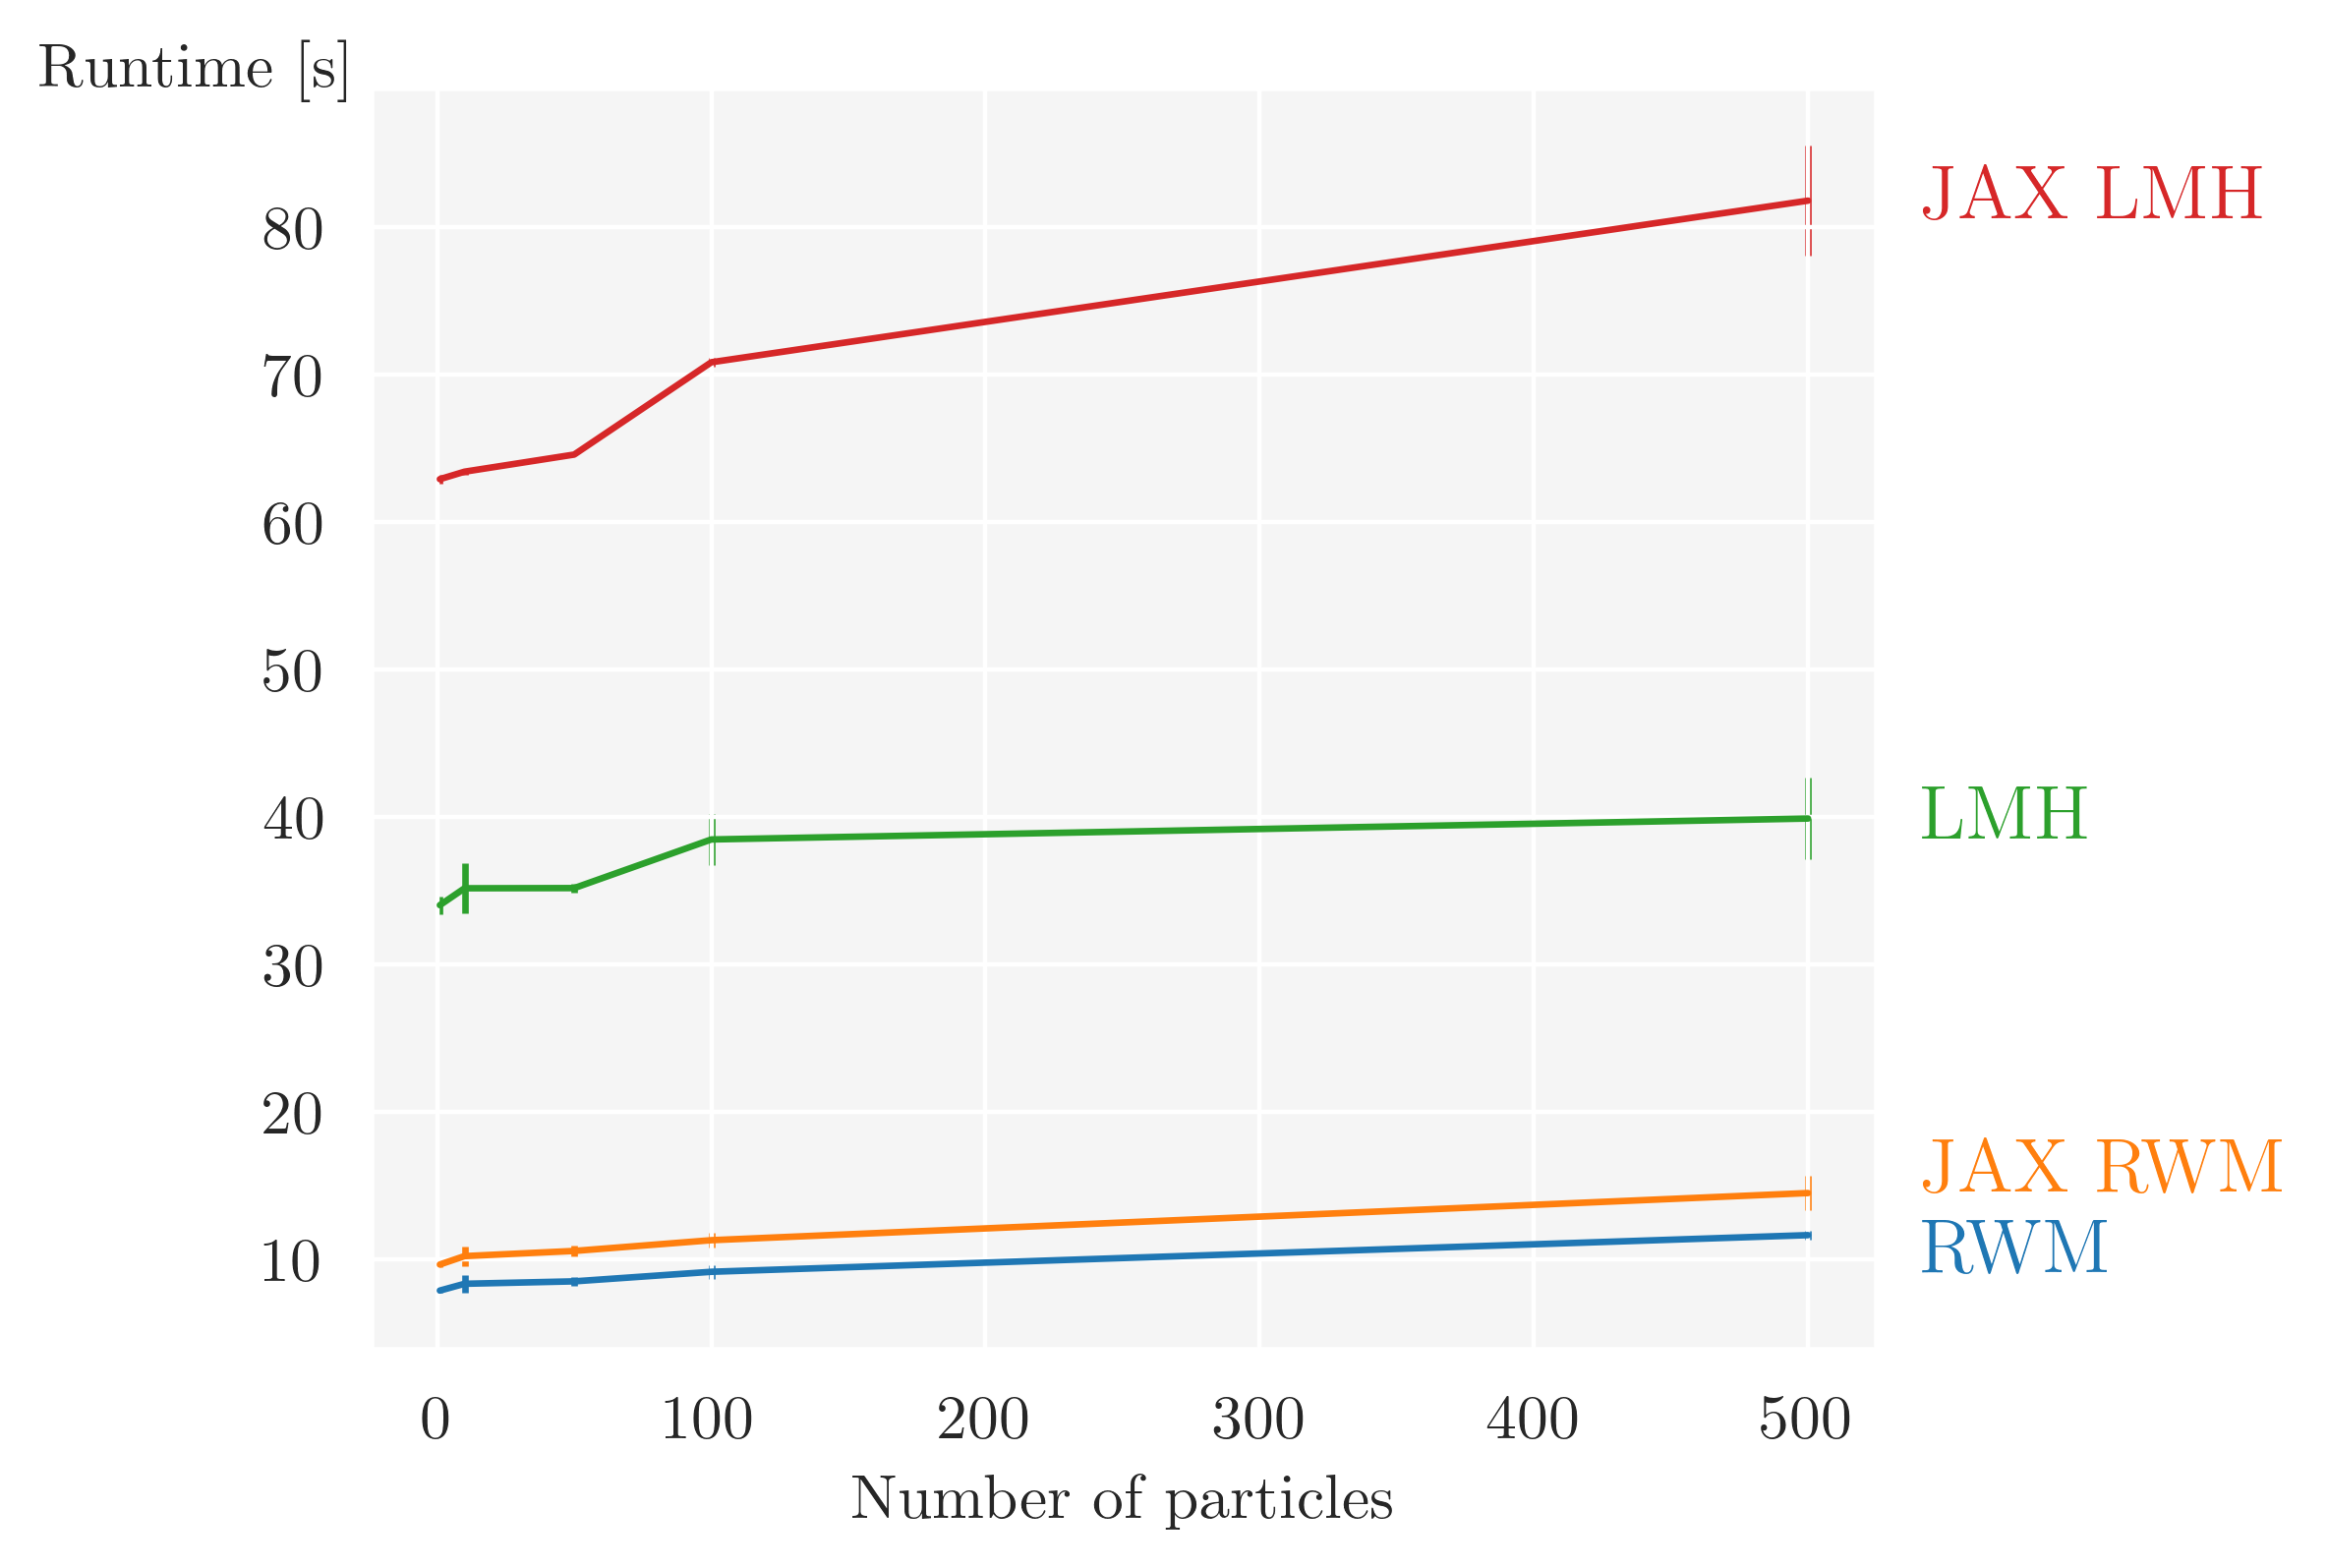

In [35]:
line_plot(datasets, ["N", "Mean_time", "Std_time"], ["RWM", "JAX RWM", "LMH", "JAX LMH"], "Number of particles", "Runtime [s]", "runtime_comparisons.pdf")

In [ ]:
df_NI_LMH = pd.read_csv(data_path + "aehonib_LMH.csv")
df_NI_LMH

In [ ]:
df_I_LMH = pd.read_csv(data_path + "aehoib_LMH.csv")
df_I_LMH

In [ ]:
df_NI_RWM = pd.read_csv(data_path + "aehonib_RWM.csv")
df_NI_RWM